In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time

In [2]:
# Step 1: Load the dataset
data = pd.read_csv("Fraud.csv")

In [3]:
print(data.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [4]:
# Step 2: Display basic information
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
# Step 3: Check for missing values
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


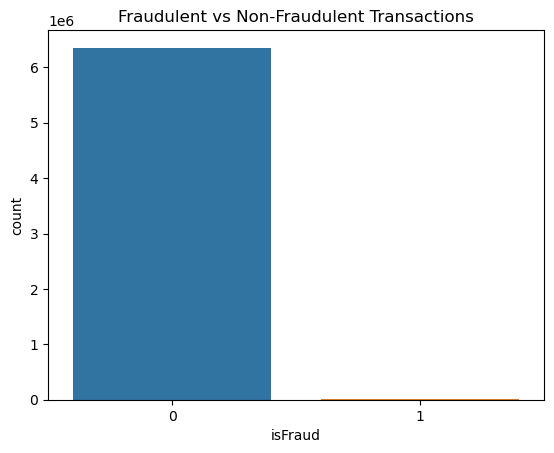

In [6]:
# Step 4: Exploratory Data Analysis (EDA)
# Class distribution
sns.countplot(x='isFraud', data=data)
plt.title("Fraudulent vs Non-Fraudulent Transactions")
plt.show()

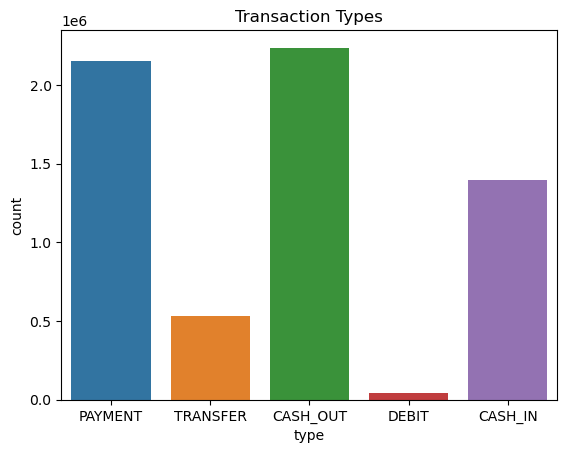

In [7]:
# Distribution of transaction types
sns.countplot(x='type', data=data)
plt.title("Transaction Types")
plt.show()

In [8]:
# Step 5: Feature Engineering
# Encode 'type' feature
data = pd.get_dummies(data, columns=['type'], drop_first=True)

In [9]:
# Create a new feature: Transaction Difference
data['transaction_diff'] = data['oldbalanceOrg'] - data['newbalanceOrig']


In [10]:
# Step 6: Outlier Detection
# Detect outliers using IQR
numeric_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'transaction_diff']
for col in numeric_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))).sum()
    print(f"Outliers in {col}: {outliers}")


Outliers in amount: 338078
Outliers in oldbalanceOrg: 1112507
Outliers in newbalanceOrig: 1053391
Outliers in transaction_diff: 2139299


In [11]:
# Step 7: Multi-Collinearity Check
X_temp = data.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)
scaler_temp = StandardScaler()
X_temp_scaled = scaler_temp.fit_transform(X_temp)

In [12]:
# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X_temp.columns
vif_data['VIF'] = [variance_inflation_factor(X_temp_scaled, i) for i in range(X_temp_scaled.shape[1])]
print("Variance Inflation Factor (VIF):\n", vif_data)

C:\Users\JOHN\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factor (VIF):
              Feature        VIF
0               step   1.002760
1             amount   4.045355
2      oldbalanceOrg        inf
3     newbalanceOrig        inf
4     oldbalanceDest  68.106446
5     newbalanceDest  78.400274
6     isFlaggedFraud   1.000648
7      type_CASH_OUT   2.931081
8         type_DEBIT   1.055551
9       type_PAYMENT   2.810034
10     type_TRANSFER   1.810874
11  transaction_diff        inf


In [13]:
# Step 8: Split features and target
X = data.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)
y = data['isFraud']

In [14]:
# Step 9: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Step 10: Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [16]:
# Step 11: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


In [17]:
#import time  # Add this import statement

# Step 12: Model Development
start_time = time.time()
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=50, max_depth=10)
model.fit(X_train, y_train)
end_time = time.time()
print(f"Model training completed in {end_time - start_time:.2f} seconds.")


Model training completed in 418.26 seconds.


In [18]:
# Step 13: Model Evaluation
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99   1906309
           1       0.99      1.00      0.99   1906336

    accuracy                           0.99   3812645
   macro avg       0.99      0.99      0.99   3812645
weighted avg       0.99      0.99      0.99   3812645

Confusion Matrix:
 [[1878646   27663]
 [   4334 1902002]]


In [19]:
# AUC-ROC Score
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("AUC-ROC Score:", roc_auc)

AUC-ROC Score: 0.9996592602628049


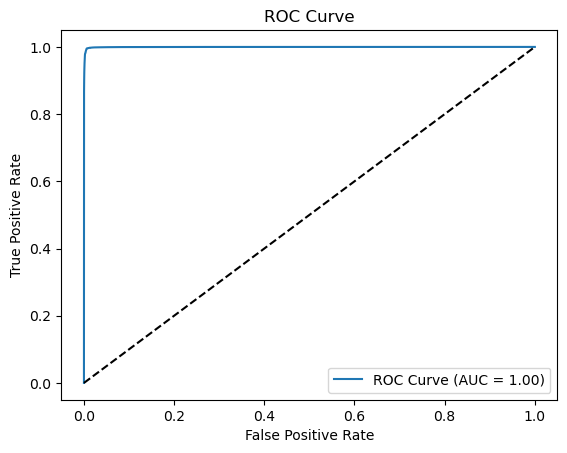

In [20]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [21]:
# Step 14: Feature Importance
importance = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:\n", importance_df)

Feature Importances:
              Feature  Importance
11  transaction_diff    0.328326
2      oldbalanceOrg    0.177212
1             amount    0.139597
3     newbalanceOrig    0.105194
10     type_TRANSFER    0.071808
9       type_PAYMENT    0.048191
5     newbalanceDest    0.040974
0               step    0.039394
7      type_CASH_OUT    0.027875
4     oldbalanceDest    0.020428
6     isFlaggedFraud    0.000775
8         type_DEBIT    0.000226


In [22]:
# Step 15: Insights and Recommendations
# Write recommendations based on results and insights gained from the analysis.
print("Key Predictors of Fraudulent Transactions:")
print(importance_df.head())

Key Predictors of Fraudulent Transactions:
             Feature  Importance
11  transaction_diff    0.328326
2      oldbalanceOrg    0.177212
1             amount    0.139597
3     newbalanceOrig    0.105194
10     type_TRANSFER    0.071808


In [23]:
# Explanation of key predictors
print("\nAnalysis of Key Predictors:")
for index, row in importance_df.head().iterrows():
    print(f"Feature: {row['Feature']} - Importance: {row['Importance']:.4f}")
    print(f"  Explanation: {row['Feature']} influences fraudulent activity due to its relationship with financial anomalies such as balance mismatches or large transaction values.")


Analysis of Key Predictors:
Feature: transaction_diff - Importance: 0.3283
  Explanation: transaction_diff influences fraudulent activity due to its relationship with financial anomalies such as balance mismatches or large transaction values.
Feature: oldbalanceOrg - Importance: 0.1772
  Explanation: oldbalanceOrg influences fraudulent activity due to its relationship with financial anomalies such as balance mismatches or large transaction values.
Feature: amount - Importance: 0.1396
  Explanation: amount influences fraudulent activity due to its relationship with financial anomalies such as balance mismatches or large transaction values.
Feature: newbalanceOrig - Importance: 0.1052
  Explanation: newbalanceOrig influences fraudulent activity due to its relationship with financial anomalies such as balance mismatches or large transaction values.
Feature: type_TRANSFER - Importance: 0.0718
  Explanation: type_TRANSFER influences fraudulent activity due to its relationship with financia

In [24]:
# Recommendations for Fraud Prevention
print("\nRecommendations:")
print("1. Implement stricter monitoring for large transactions or balance discrepancies.")
print("2. Use real-time anomaly detection systems to flag unusual patterns.")
print("3. Enhance authentication processes for high-value transactions.")



Recommendations:
1. Implement stricter monitoring for large transactions or balance discrepancies.
2. Use real-time anomaly detection systems to flag unusual patterns.
3. Enhance authentication processes for high-value transactions.


In [25]:
# Step 16: Implementation Evaluation
print("\nImplementation Evaluation:")
print("1. Track fraud detection rates before and after deploying the updated model.")
print("2. Measure customer satisfaction by analyzing false-positive rates.")
print("3. Regularly update the model based on new patterns and feedback.")


Implementation Evaluation:
1. Track fraud detection rates before and after deploying the updated model.
2. Measure customer satisfaction by analyzing false-positive rates.
3. Regularly update the model based on new patterns and feedback.
